In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Libraries for model training
from statsmodels.formula import api
from sklearn.linear_model import LinearRegression

# Libraries used to reduce collinearity and feature selection
from sklearn.feature_selection import RFE

# Libraries used for Standardisation
from sklearn.preprocessing import StandardScaler

# Libraries for tarin-test split
from sklearn.model_selection import train_test_split

# For performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [60]:
seven_eleven = pd.read_csv('./seven_eleven_sales.csv')

original_data = seven_eleven.copy(deep=True)

seven_eleven.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## EDA

**Date Time Treatment**

In [61]:
seven_eleven['Date'] = pd.to_datetime(seven_eleven['Date'], dayfirst=True)

# introducing extra column of weekday, month and year
seven_eleven['weekday'] = seven_eleven.Date.dt.weekday
seven_eleven['year'] = seven_eleven.Date.dt.year
seven_eleven['month'] = seven_eleven.Date.dt.month

seven_eleven.drop(['Date'], axis='columns', inplace=True)

seven_eleven.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,year,month
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2010,2
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2010,2
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2010,2
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2010,2
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,2010,3


In [62]:
target = 'Weekly_Sales'

features = [x for x in seven_eleven.columns if x not in [target]]
features

['Store',
 'Holiday_Flag',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'weekday',
 'year',
 'month']

**Checking for Nulls**

In [63]:
seven_eleven.shape

(6435, 10)

In [64]:
seven_eleven.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   year          6435 non-null   int64  
 9   month         6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


#### Univariate Analysis

Segregating categorical features and numerical features

In [65]:
seven_eleven.nunique().sort_values()

weekday            1
Holiday_Flag       2
year               3
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [66]:
catF = []
numF = []

for x in features:
    if seven_eleven[x].nunique() <= 45:
        catF.append(x)
    else:
        numF.append(x)

print("Categorical Features:", catF)
print("Numerical Features: ", numF)

Categorical Features: ['Store', 'Holiday_Flag', 'weekday', 'year', 'month']
Numerical Features:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


- For Target variable

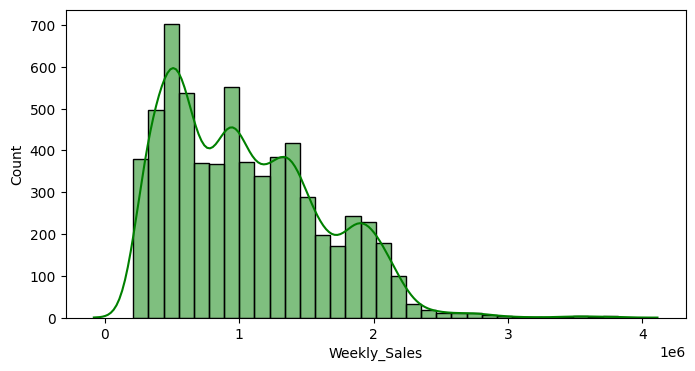

In [67]:
plt.figure(figsize=[8,4])
sns.histplot(seven_eleven[target], bins=32, kde=True, color='green', kde_kws=dict(cut=3))
plt.show()

From the above graph we get to know that there the number of lower values sales are more compared to higher value sales.

- **For Categorical Variables**

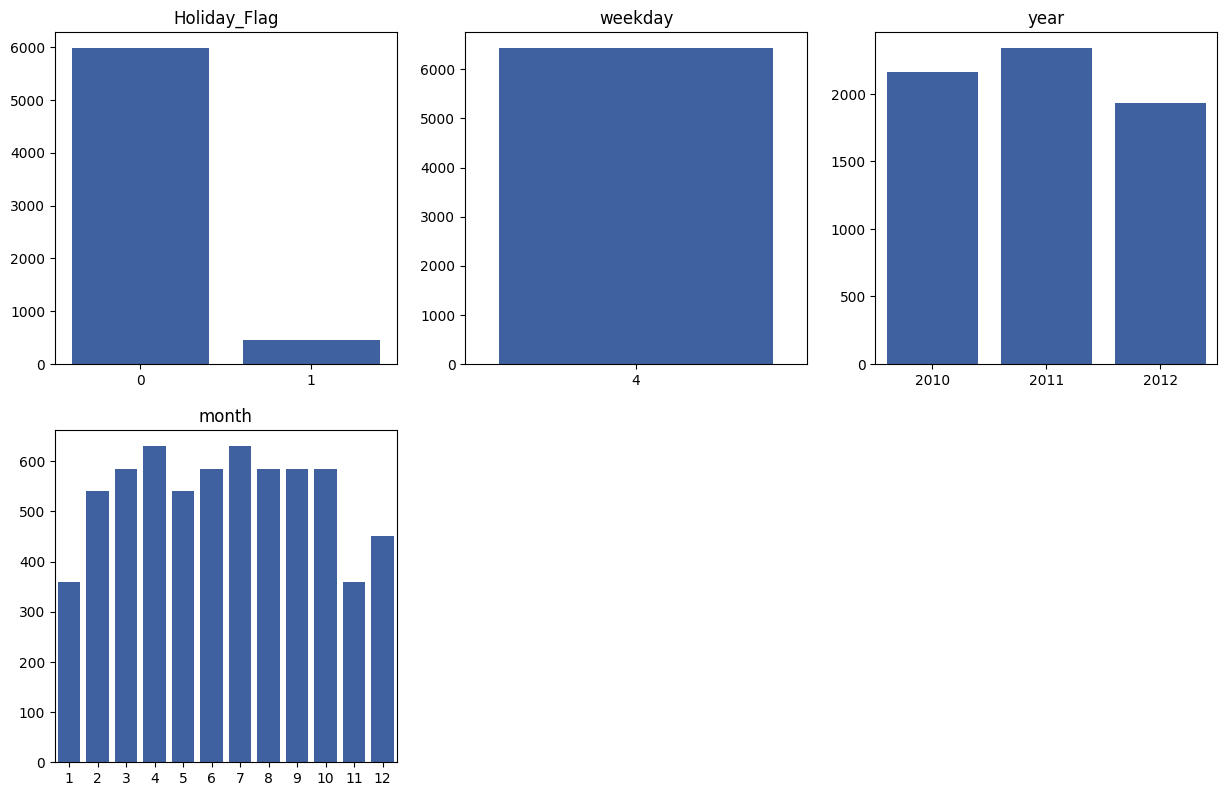

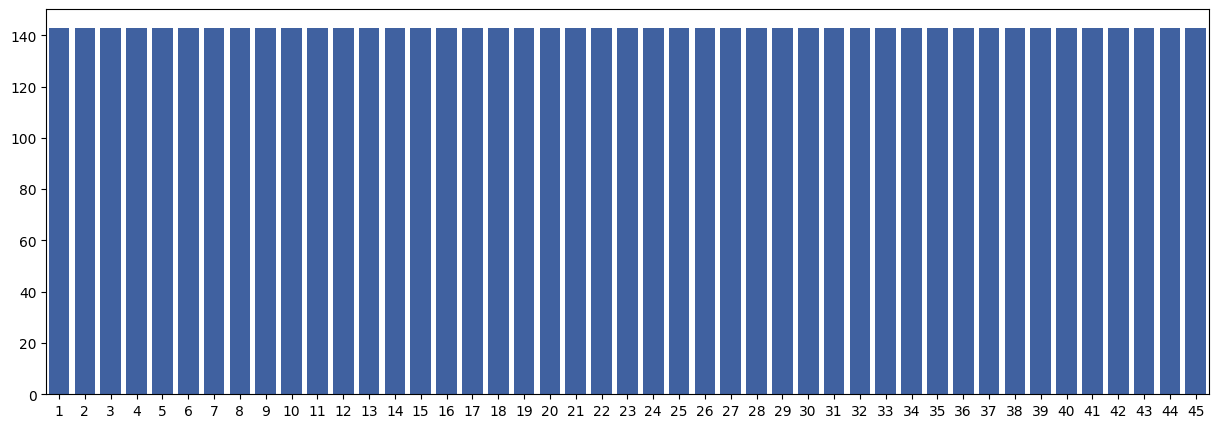

In [68]:
plt.figure(figsize = [len(catF)*3, 25])
for i in range(1, len(catF)):
    temp = seven_eleven[catF[i]].value_counts()
    plt.subplot(5, math.ceil(len(catF)/2), i)
    sns.barplot(x = temp.index, y = temp.values, color="#305cb0")
    plt.title(catF[i])
plt.show()

plt.figure(figsize = [len(catF)*3, 5])
temp = seven_eleven[catF[0]].value_counts()
sns.barplot(x = temp.index, y = temp.values, color="#305cb0")
plt.show()

**Insights**:
  - There are approx 500 entries of weekly sales corresponding to a holiday period. The significance of these sales could be determined by bivariate analysis.
  - All the stores have equal weekly sales entries.(~ 143)
  - Year 2011 have maximum number of weekly sales. This could be due to the fact that the dataset does not have data for complete 3 years.
  - Weekly sales (including all years and all stores) is max for April(4) and July(7) and are almost equal.

- **For numerical Variables**

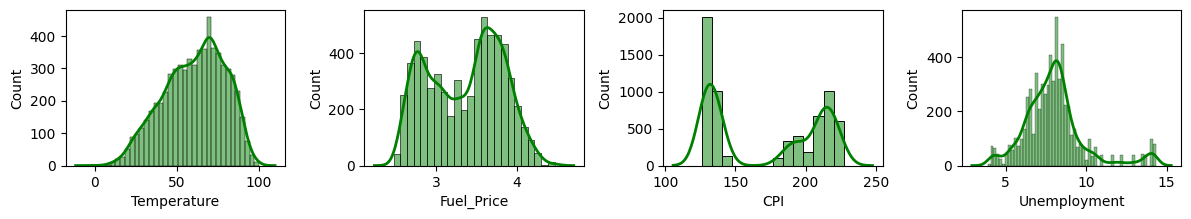

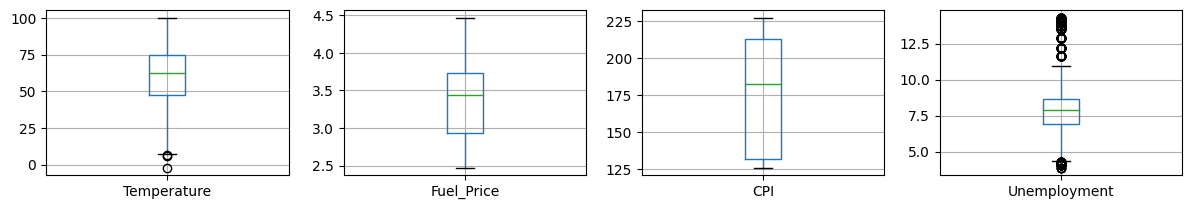

In [69]:
plt.figure(figsize=[15,4*math.ceil(len(numF)/4)])

for i in range(len(numF)):
    plt.subplot(2, 5, i+1)
    sns.histplot(seven_eleven[numF[i]], kde=True, kde_kws=dict(cut=3), line_kws=dict(linewidth=2.0), color='green')
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4*math.ceil(len(numF)/4)])
for i in range(len(numF)):
    plt.subplot(2, 5, i+1)
    seven_eleven.boxplot(numF[i])
plt.tight_layout()
plt.show()

**Insights:**
  - All the features, except CPI, follows Normal distribution
  - CPI follows a bi-modal distribution
  - There are some outliers which need to be handled

### Bi-variate analysis of numerical features to check for collinearity

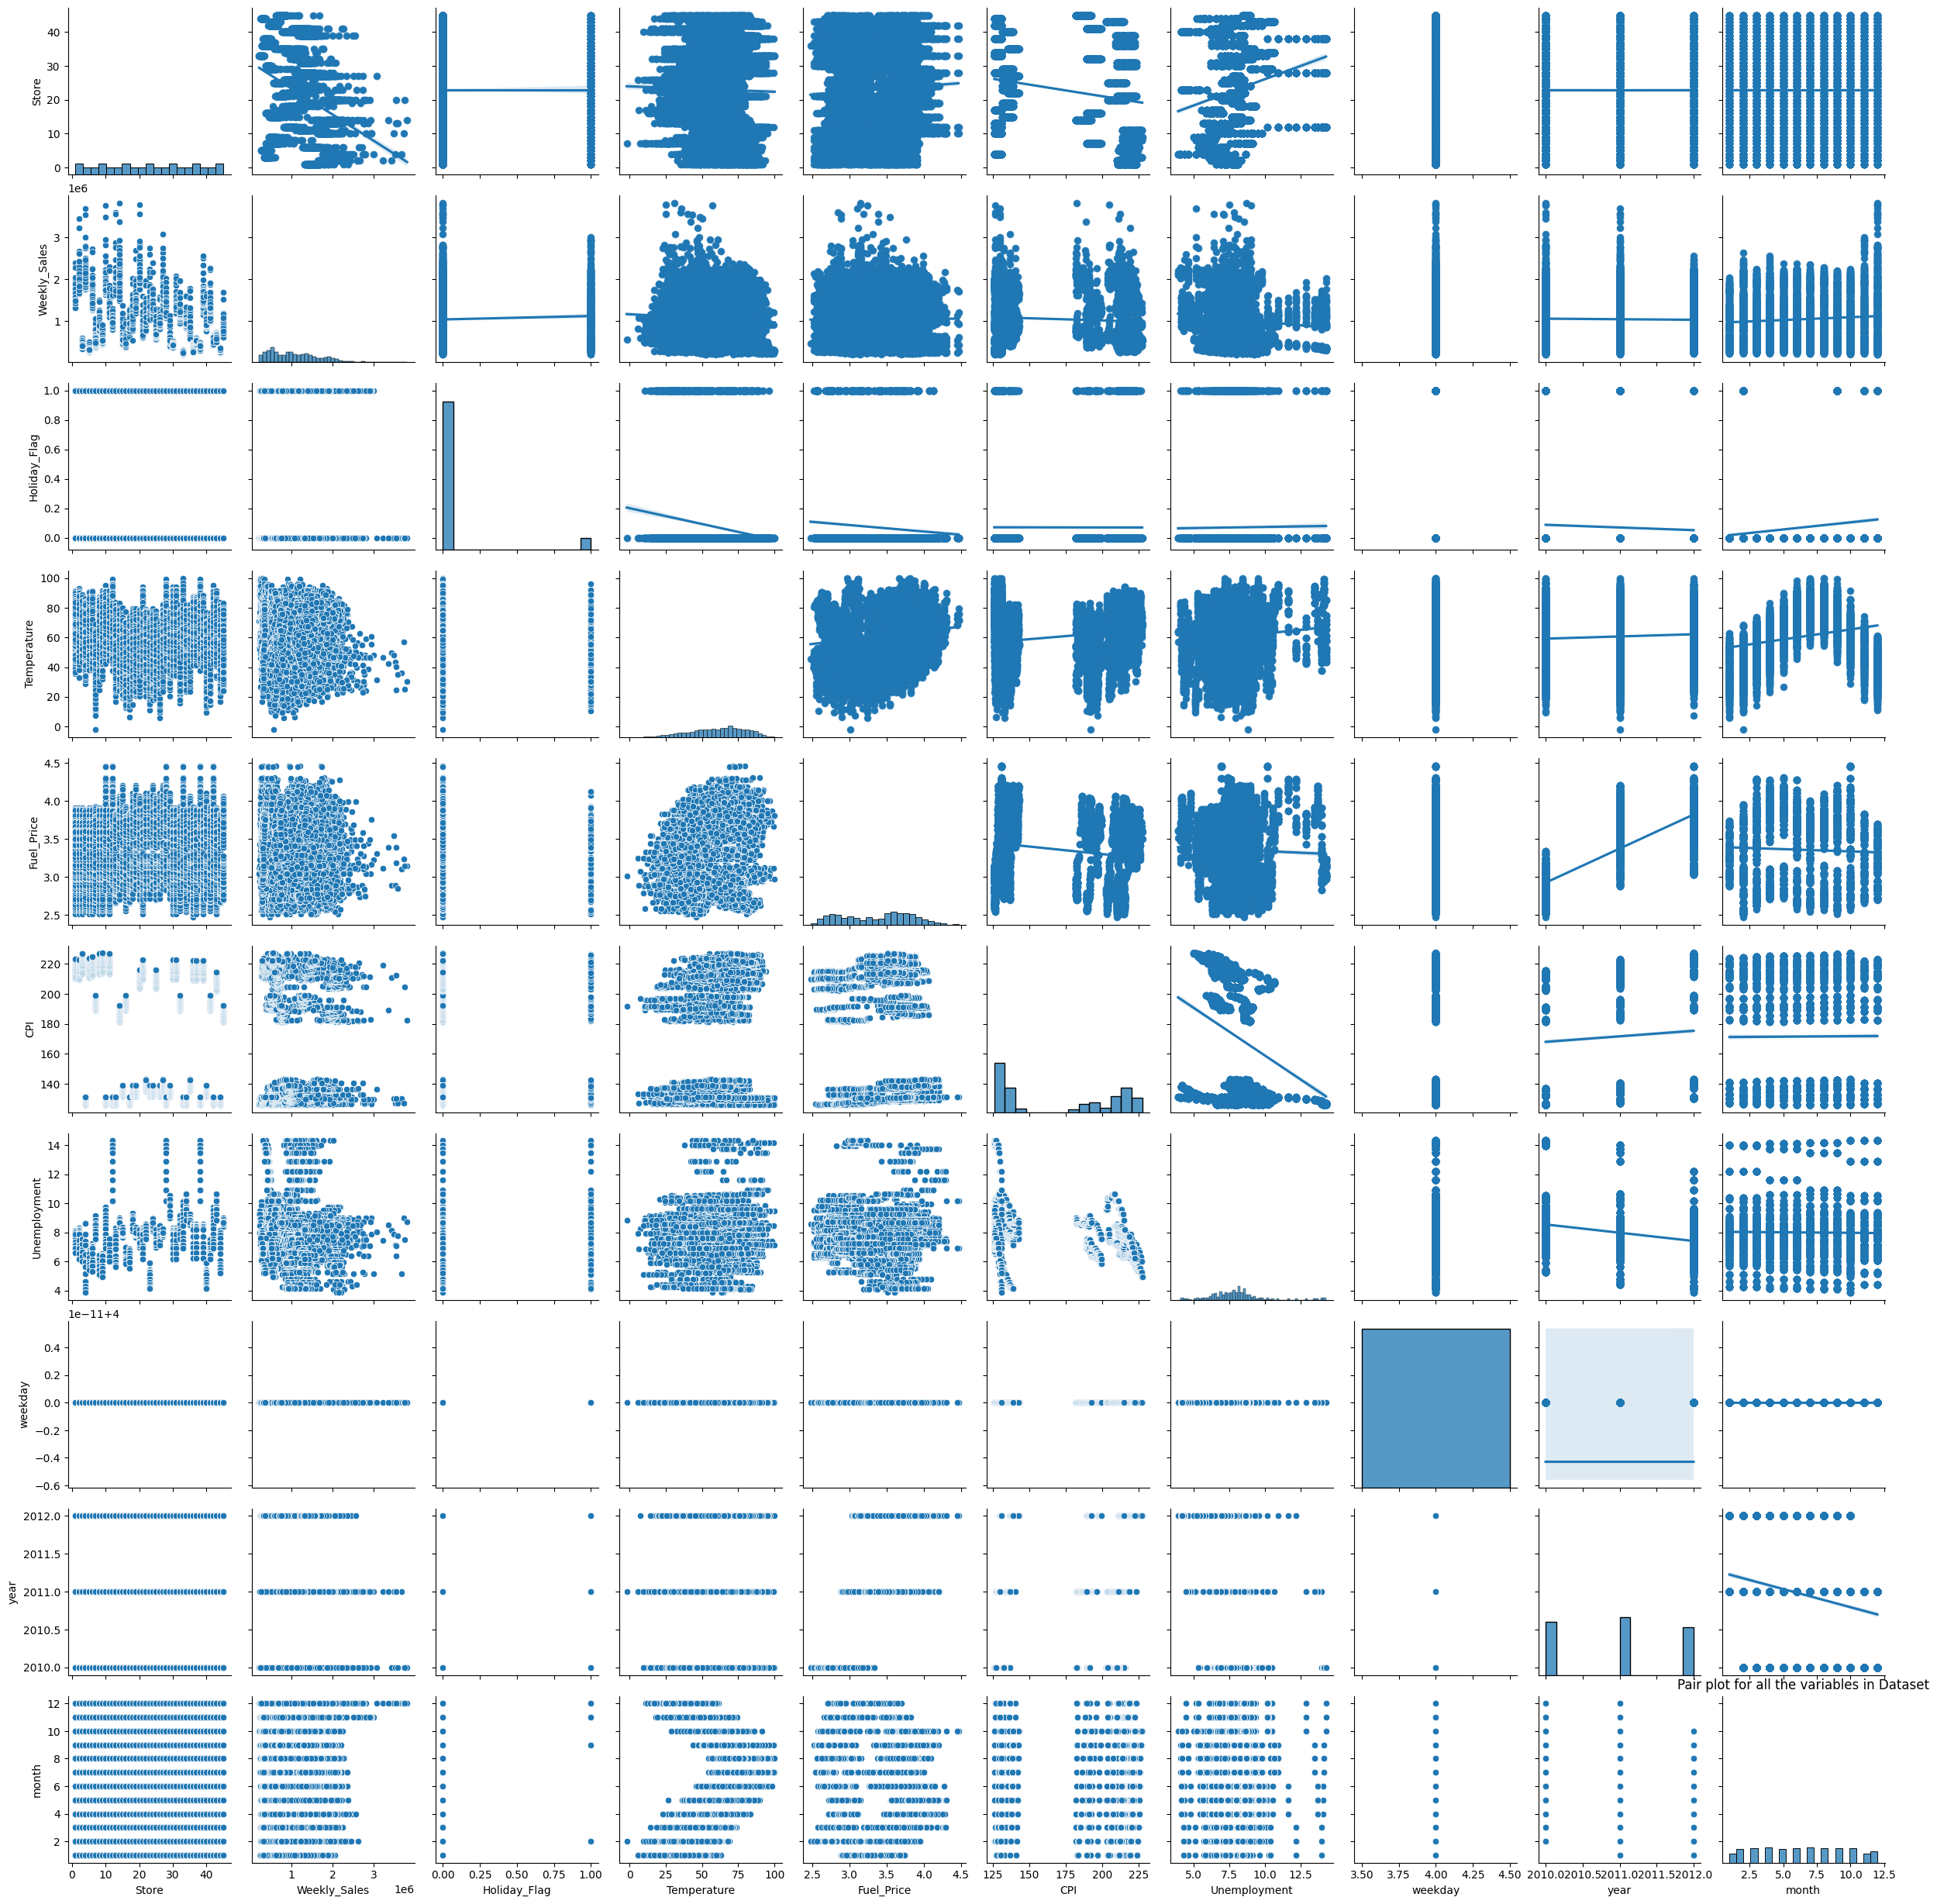

In [70]:
pairPlot = sns.pairplot(seven_eleven)
plt.title("Pair plot for all the variables in Dataset")
pairPlot.map_upper(sns.regplot)
plt.show()

<AxesSubplot: >

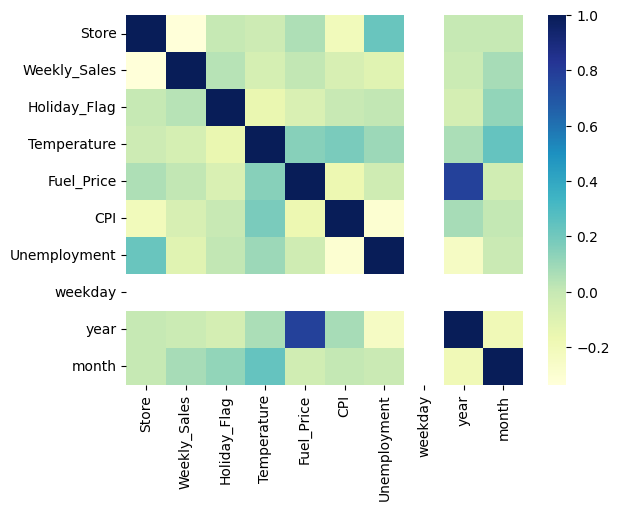

In [71]:
heatmap_data = seven_eleven.corr()
sns.heatmap(heatmap_data, cmap='YlGnBu')

**Insights:**
- There are a lot of pairs which are correlated. Hence, multicollinearity needs to be addressed.

### Bivariate analysis of the weekly sales for different categorical variables

Categorical variables present:
- Store
- Holiday_Flag
- weekday
- year
- month

- **Analysing total weekly_sales and average weekly_sales based on `Holiday_Flag`**

<AxesSubplot: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

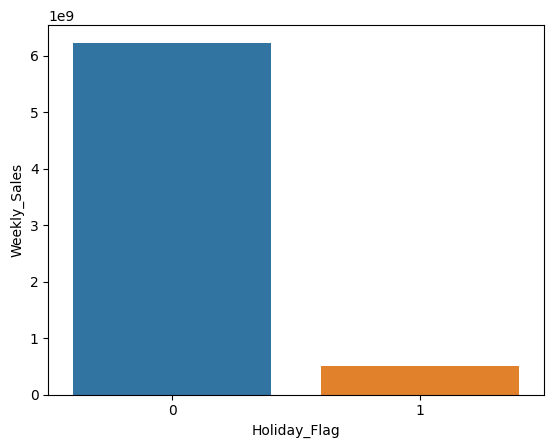

In [72]:
# Total weekly sales
totalWeeklysales_hf = seven_eleven[['Holiday_Flag', 'Weekly_Sales']].groupby('Holiday_Flag').sum()
sns.barplot(data=totalWeeklysales_hf, y='Weekly_Sales', x=totalWeeklysales_hf.index)

<AxesSubplot: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

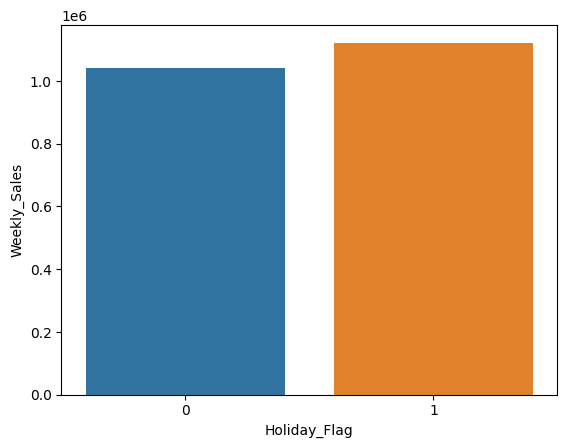

In [73]:
avgWeeklySales_hf = seven_eleven[['Holiday_Flag', 'Weekly_Sales']].groupby('Holiday_Flag').mean()
sns.barplot(data=avgWeeklySales_hf, y='Weekly_Sales', x=avgWeeklySales_hf.index)

**Insights:**
- Total sales for non-holiday days were more than that of holiday days
- Average sales is much greater for holiday days

- **Average and total Weekly_Sales based on `months`**

<AxesSubplot: xlabel='month', ylabel='Weekly_Sales'>

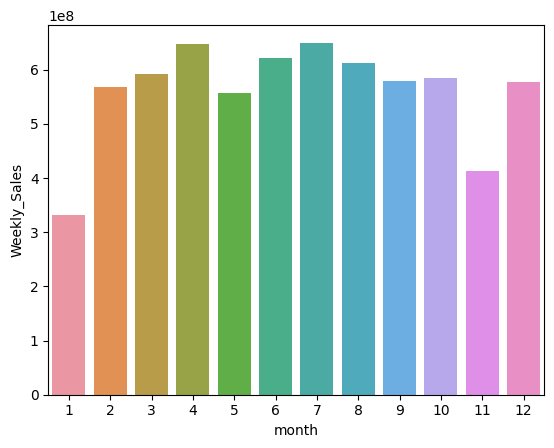

In [74]:
totalWeeklysales_months = seven_eleven[['Weekly_Sales', 'month']].groupby('month').sum()
sns.barplot(data=totalWeeklysales_months, x = totalWeeklysales_months.index, y='Weekly_Sales')

<AxesSubplot: xlabel='month', ylabel='Weekly_Sales'>

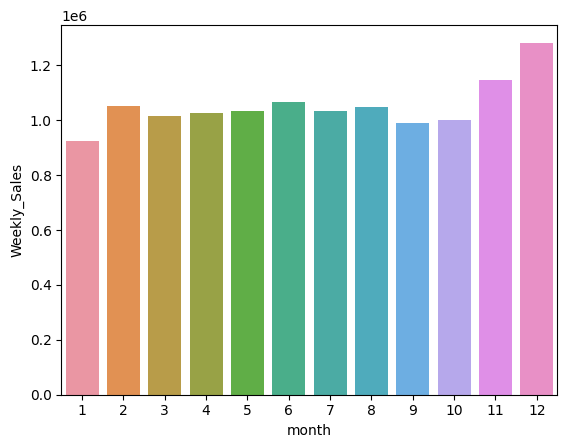

In [75]:
avgWeeklysales_months = seven_eleven[['Weekly_Sales', 'month']].groupby('month').mean()
sns.barplot(data=avgWeeklysales_months, x = avgWeeklysales_months.index, y='Weekly_Sales')

**Insights:**
- Total sales for the month of Aprli (4) and July (7) are highest and almost equal.
- But there may be some anomaly in total sales bcz the dataset does not contain record for complete 3 years, so its better to look for the average sales.
- The average sales in December (12) is highest; November (11) also show good amount of average sales.
- The high average sales during the holidays and in December and November implies that most of the significant holidays occurred in the month of November and December.

<AxesSubplot: xlabel='Store', ylabel='Weekly_Sales'>

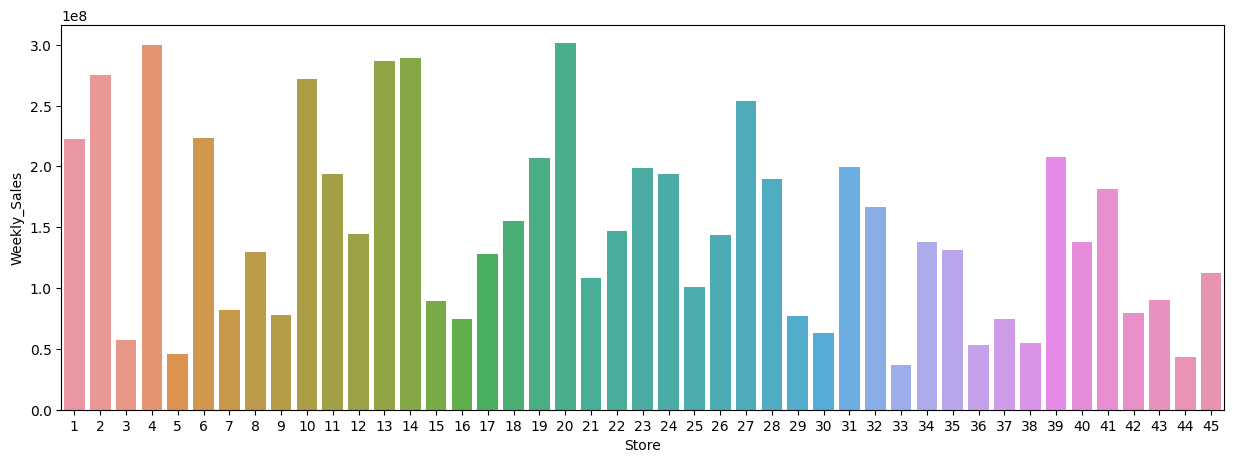

In [76]:
plt.figure(figsize=[15, 5])
totalWeeklysales_store = seven_eleven[['Weekly_Sales', 'Store']].groupby('Store').sum()
sns.barplot(data=totalWeeklysales_store, x = totalWeeklysales_store.index, y='Weekly_Sales')

**Insights:** The sales vary a lot from store to store.

***Hence, `Holiday_Flag` and `month` are crucial features for our model. `Sales` can also be a good impacting feature.***

### Feature Engineering

- **One-hot encoding**

In [77]:
categories_dummy = pd.DataFrame()
for ele in catF:
    temp = pd.get_dummies(seven_eleven[ele], drop_first=True, prefix=str(ele))
    categories_dummy = pd.concat([categories_dummy, temp], axis='columns')

seven_eleven_dummy = pd.concat([seven_eleven, categories_dummy], axis='columns')
seven_eleven_dummy.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,year,month,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2010,2,...,0,0,0,0,0,0,0,0,0,0
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2010,2,...,0,0,0,0,0,0,0,0,0,0
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2010,2,...,0,0,0,0,0,0,0,0,0,0
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2010,2,...,0,0,0,0,0,0,0,0,0,0
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,2010,3,...,1,0,0,0,0,0,0,0,0,0


- **Outliers treatment**

In [78]:
seven_eleven_new = seven_eleven_dummy.copy()
for ele in numF:
    q1 = seven_eleven_new[ele].quantile(0.25)
    q3 = seven_eleven_new[ele].quantile(0.75)

    interq = q3 - q1
    seven_eleven_new = seven_eleven_new[(seven_eleven_new[ele] <= (q3+1.5*interq)) & (seven_eleven_new[ele] >= (q1-1.5*interq))]
    seven_eleven_new = seven_eleven_new.reset_index(drop=True)
seven_eleven_new.shape

(5951, 68)

**Impact of removal of outliers**

In [79]:
print('Before outlier removal, the dataset had {} rows'.format(seven_eleven_dummy.shape[0]))
print('After outlier removal, the dataset has {} rows'.format(seven_eleven_new.shape[0]))

Before outlier removal, the dataset had 6435 rows
After outlier removal, the dataset has 5951 rows


([<matplotlib.patches.Wedge at 0x23afba2dd10>,
 [Text(-1.0694342970374702, -0.2575078335118606, 'Retained'),
  Text(1.0694343030648756, 0.2575078084799446, 'Dropped')],
 [Text(-0.4861064986533955, -0.11704901523266388, '92.479%'),
  Text(0.4861065013931253, 0.11704900385452026, '7.521%')])

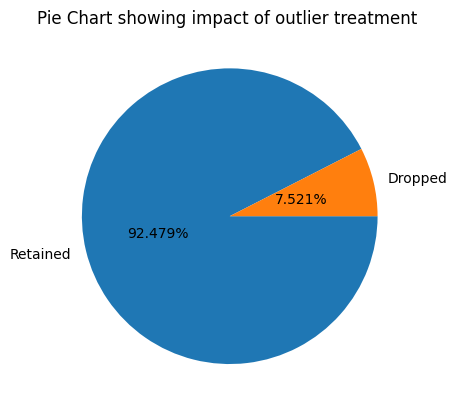

In [80]:
plt.title('Pie Chart showing impact of outlier treatment ')
plt.pie([seven_eleven_new.shape[0], original_data.shape[0]-seven_eleven_new.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.3f%%', pctdistance=0.5)

In [81]:
seven_eleven_new.drop(['month', 'Store', 'Holiday_Flag_1', 'year'], axis='columns', inplace=True)

- **Standardization**

In [82]:
X = seven_eleven_new.drop([target], axis='columns')
Y = seven_eleven_new[target]

Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.75, test_size=0.25)

Train_X.reset_index(drop=True, inplace=True)

print("Train Dataset->\n", Train_X, Train_Y)
print("Test Dataset->\n", Test_X, Test_Y)

Train Dataset->
       Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0                0        56.53       4.153  142.863363         8.000   
1                0        82.41       3.648  213.791715         8.300   
2                0        24.26       3.113  196.943271         8.256   
3                0        61.24       3.130  126.546161         9.003   
4                0        71.93       3.884  142.405448         7.753   
...            ...          ...         ...         ...           ...   
4458             0        63.27       4.034  134.767774         4.781   
4459             0        20.67       3.437  133.614143         5.114   
4460             0        45.56       3.360  223.707902         5.825   
4461             0        56.87       2.805  126.471333         7.896   
4462             0        77.46       3.666  226.518093         6.334   

      weekday  Store_2  Store_3  Store_4  Store_5  ...  month_3  month_4  \
0           4        0        

In [83]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('_', StandardScaler(), ['CPI', 'Temperature', 'Fuel_Price', 'Unemployment'])], remainder='passthrough')


In [84]:
Train_X_std = ct.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns = Train_X.columns)
Train_X_std.describe()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,Store_2,Store_3,Store_4,Store_5,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,4.463000e+03,4.463000e+03,4.463000e+03,4.463000e+03,4463.000000,4463.0,4463.000000,4463.000000,4463.000000,4463.000000,...,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000,4463.000000
mean,-2.563240e-16,3.359277e-16,-9.234031e-17,4.617015e-16,0.072149,4.0,0.025991,0.024423,0.021062,0.024647,...,0.087609,0.097916,0.079991,0.091194,0.100381,0.092539,0.091866,0.090746,0.055792,0.072821
std,1.000112e+00,1.000112e+00,1.000112e+00,1.000112e+00,0.258763,0.0,0.159128,0.154376,0.143607,0.155065,...,0.282757,0.297235,0.271310,0.287917,0.300541,0.289817,0.288870,0.287280,0.229545,0.259872
min,-1.244575e+00,-2.880127e+00,-1.795418e+00,-2.777169e+00,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.073041e+00,-7.272097e-01,-9.804332e-01,-6.761170e-01,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.841871e-01,1.193760e-01,1.675562e-01,9.445780e-02,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.960319e-01,7.807030e-01,8.423286e-01,6.146566e-01,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.346080e+00,2.162390e+00,2.487634e+00,2.585254e+00,1.000000,4.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
Test_X_std = ct.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=Test_X.columns)
Test_X_std.describe()

,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,Store_2,Store_3,Store_4,Store_5,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.0,1488.000000,1488.000000,1488.000000,1488.000000,...,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000
mean,0.027484,-0.016891,0.061527,-0.048360,0.064516,4.0,0.018145,0.022849,0.021505,0.022177,...,0.097446,0.096102,0.093414,0.086694,0.094086,0.089382,0.091398,0.094758,0.058468,0.063844
std,0.997356,1.007481,1.007161,1.026628,0.245753,0.0,0.133521,0.149474,0.145110,0.147310,...,0.296664,0.294830,0.291110,0.281480,0.292047,0.285390,0.288271,0.292979,0.234705,0.244557
min,-1.244252,-2.728873,-1.885242,-2.777169,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.073191,-0.768016,-0.902659,-0.725747,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.418082,0.097069,0.294624,0.057185,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.012638,0.755539,0.879573,0.614657,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.345606,2.158581,2.487634,2.585254,1.000000,4.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now, we could determine the useful features using recursive feature elimination (RFE)

In [86]:
from sklearn.feature_selection import RFE

train_r2 = []
test_r2 = []

max_features = seven_eleven_new.shape[1] - 3

for i in range(max_features):
    rfe = RFE(LinearRegression(), n_features_to_select=seven_eleven_new.shape[1]-i)
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:, rfe.support_], Train_Y)

    predict_train = LR.predict(Train_X_std.loc[:, rfe.support_])
    predict_test = LR.predict(Test_X_std.loc[:, rfe.support_])

    train_r2.append( r2_score(y_true=Train_Y, y_pred=predict_train) )
    test_r2.append( r2_score(y_true=Test_Y, y_pred=predict_test) )

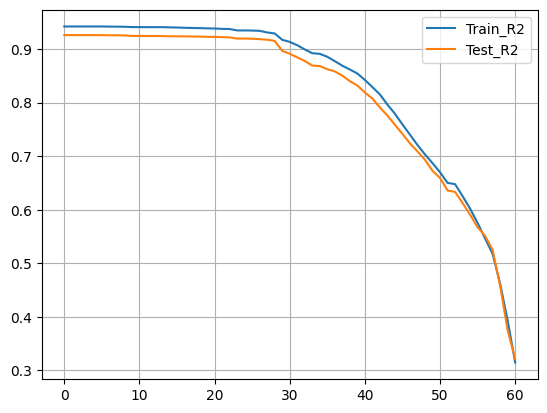

In [87]:
plt.plot(train_r2, label='Train_R2')
plt.plot(test_r2, label='Test_R2')

plt.legend()
plt.grid()
plt.show()

**From the above generated graph, it is clearly visible that removing approximately 30 features will give me a good model having a R2 > 0.9**

In [88]:
rfe = RFE(LinearRegression(), n_features_to_select=seven_eleven_new.shape[1]-28)
rfe = rfe.fit(Train_X_std, Train_Y)

LM = LinearRegression()
LM.fit(Train_X_std.loc[:, rfe.support_], Train_Y)

predict_train = LM.predict(Train_X_std.loc[:, rfe.support_])
predict_test = LM.predict(Test_X_std.loc[:, rfe.support_])

print(r2_score(y_true=Train_Y, y_pred=predict_train))
print(r2_score(y_true=Test_Y, y_pred=predict_test))

0.9290426148377171
0.9150884138002222


In [89]:
Train_X_std_rfe = Train_X_std.loc[:, rfe.support_]

In [90]:
Test_X_std_rfe = Test_X_std.loc[:, rfe.support_]

## Model training

**Multiple Linear Regression**

In [91]:
MLR = LinearRegression().fit(Train_X_std_rfe, Train_Y)

print("Co-efficient of MLR model: ", MLR.coef_)
print("Intercept of MLR model: ", MLR.intercept_)

Co-efficient of MLR model:  [  508104.50989754 -1020265.12838678   658167.46530943 -1099775.57304739
  -847375.39360805  -510581.6815134   -874288.40918056   467303.18599296
  -438344.65799339   578349.74234345   591323.69982313  -798344.36235526
  -894153.93514814  -533014.37326592  -328685.53303577   673476.87608482
  -657308.68204144  -387342.37739857  -714712.47746285  -407355.70502192
   343417.70535927  -881680.02314086  -985473.68634232  -245412.32669719
 -1165183.87108492  -462503.6919692   -492085.11705666 -1045582.17057205
  -904085.5040638   -972100.98792929  -461024.17798291  -863612.33419991
  -789986.87733653 -1116488.03171491  -639440.08665595   240403.34590337]
Intercept of MLR model:  1402967.788762621


In [92]:
predict_train = MLR.predict(Train_X_std_rfe)
predict_test = MLR.predict(Test_X_std_rfe)

C:\Users\adity\AppData\Local\Temp\ipykernel_2352\1436740511.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((Test_Y-predict_test))


Text(0.5, 1.0, 'Error Terms')

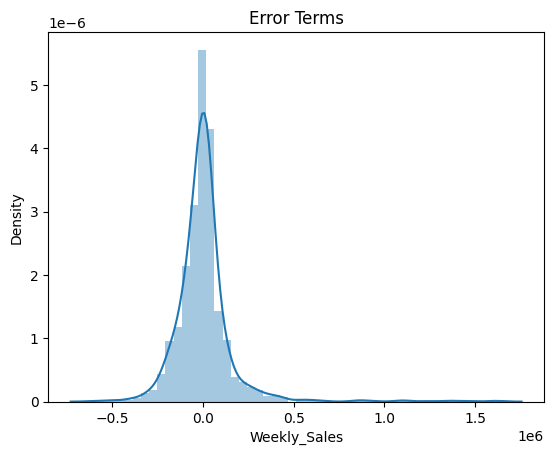

In [93]:
sns.distplot((Test_Y-predict_test))
plt.title("Error Terms")

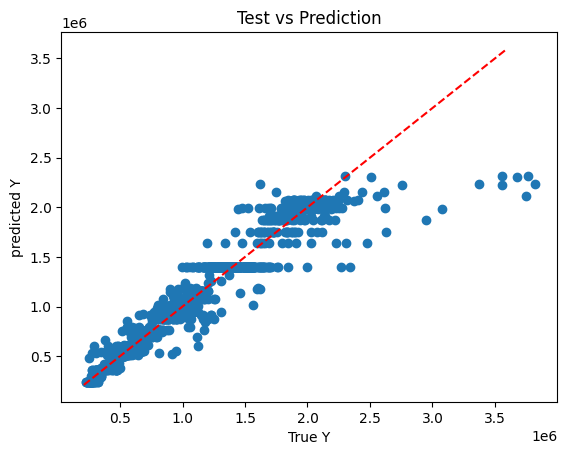

In [94]:
plt.scatter(Test_Y, predict_test)
plt.plot([Train_Y.min(), Train_Y.max()], [Train_Y.min(), Train_Y.max()], 'r--')
plt.title("Test vs Prediction")
plt.xlabel('True Y')
plt.ylabel('predicted Y')
plt.show()

In [95]:
print(r2_score(y_true=Train_Y, y_pred=predict_train))
print(r2_score(y_true=Test_Y, y_pred=predict_test))

0.9290426148377171
0.9150884138002222
